In [1]:
# CELL 1: MODIFIED (No changes needed here, setup is correct)

# Imports and Setup
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import gc # Import garbage collector

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score # Added balanced_accuracy
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Consider adding AdamW and Focal Loss if needed later
# from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.losses import CategoricalFocalCrossentropy # Requires tensorflow-addons

SEED = 42
# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- Distributed Strategy Setup --- (No changes needed)
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")

strategy = None
num_gpus = len(gpus)
if num_gpus > 1:
    print(f"Using MirroredStrategy for {num_gpus} GPUs.")
    strategy = tf.distribute.MirroredStrategy()
elif num_gpus == 1:
    print("Using single GPU.")
    # strategy = tf.distribute.get_strategy() # Default for single GPU
else:
    print("WARNING: No GPU detected. Training will be on CPU.")
    # strategy = tf.distribute.get_strategy() # Default for CPU

# --- Calculate Global Batch Size --- (No changes needed, but monitor memory)
# Aim for ~32 per GPU if possible. Adjust if OOM occurs.
per_replica_batch_size = 32 # Keep at 32, reduce to 16 or 24 if OOM
if num_gpus == 0: # CPU case
    global_batch_size = per_replica_batch_size
    print(f"Using CPU Batch Size: {global_batch_size}")
else:
    global_batch_size = per_replica_batch_size * num_gpus
    print(f"Using Global Batch Size: {global_batch_size} ({per_replica_batch_size} per replica/GPU)")

# --- NEW: Configuration ---
IMG_SIZE = 224 # Keep 224 for ResNet50V2 standard, consider 256 or 300 later if needed
N_CLASSES = 5
EPOCHS_PHASE1 = 30 # Increase epochs, rely on EarlyStopping
EPOCHS_PHASE2 = 25 # Increase epochs, rely on EarlyStopping
LR_PHASE1 = 1e-4 # Lower initial LR
LR_PHASE2 = 1e-5 # Lower fine-tuning LR
PATIENCE_EARLY_STOPPING = 10 # Increase patience
PATIENCE_REDUCE_LR = 5 # Increase patience
MIN_LR = 1e-7

Num GPUs Available: 2
Using MirroredStrategy for 2 GPUs.
Using Global Batch Size: 64 (32 per replica/GPU)


In [5]:
pip install tensorflow addon

  Preparing metadata (setup.py) ... done
  Created wheel for addon: filename=addon-0.0.2-py3-none-any.whl size=1365 sha256=ebd9d8de2c189e88571201c49a2de16b1fbafcaaf3188dfcd4d4fd3ad720ac28
  Stored in directory: /root/.cache/pip/wheels/dc/65/a1/ffff77349a9f8c2d12ff166578d5119d808eff1d9b662e2b97
Successfully built addon
Note: you may need to restart the kernel to use updated packages.


Original Dataset shape: (35108, 2)
       id_code  diagnosis
0   10003_left          0
1  10003_right          0
2   10007_left          0
3  10007_right          0
4   10009_left          0

Missing values per column:
id_code      0
diagnosis    0
dtype: int64


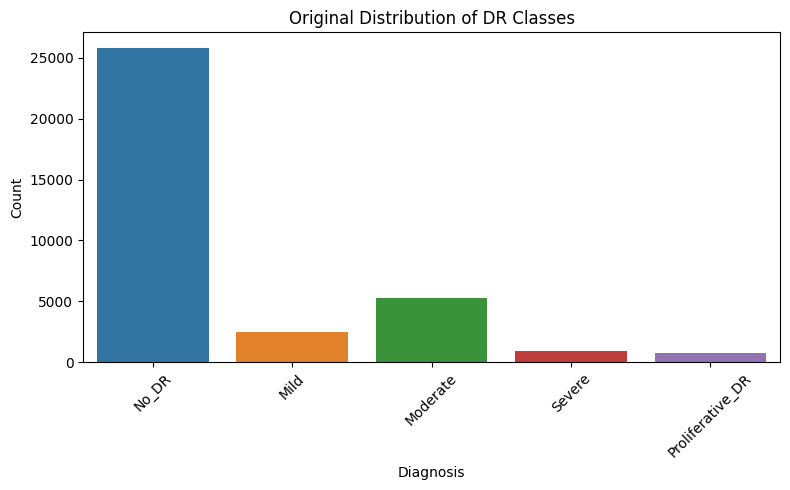


Shape after oversampling minority classes (<= 5000): (43990, 3)


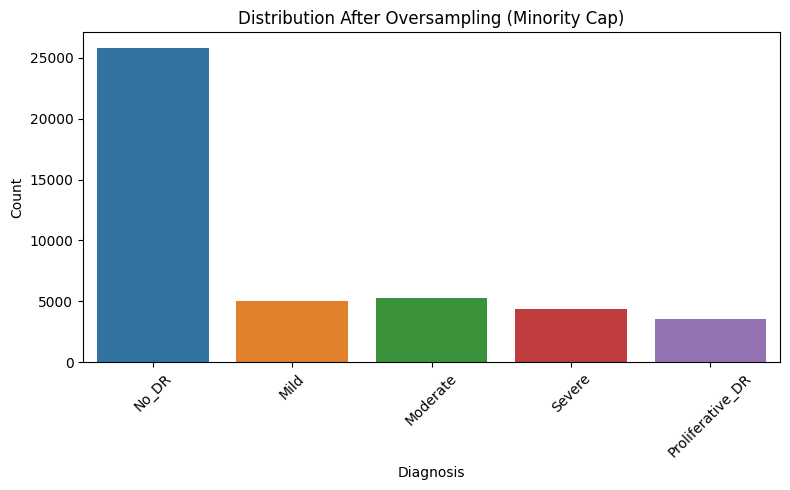

In [2]:
# CELL 2: MODIFIED (Add Oversampling Info)

# Load the CSV file containing your metadata
df = pd.read_csv('/kaggle/input/diabetic-retinopathy-dataset-ben-graham-applied/train.csv')
print("Original Dataset shape:", df.shape)
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Map diagnosis to class names
diagnosis_mapping = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative_DR'
}
df['class_name'] = df['diagnosis'].map(diagnosis_mapping)

# Plot ORIGINAL class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='class_name', data=df, order=list(diagnosis_mapping.values()))
plt.title("Original Distribution of DR Classes")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- NEW: Simple Oversampling Strategy ---
# Determine the target count (e.g., the count of the majority class or a fraction of it)
# Let's aim for a less extreme imbalance, e.g., max 4000-5000 samples per minority class
# to avoid excessive duplication. Adjust `max_samples_per_minority` as needed.
counts = df['diagnosis'].value_counts()
majority_count = counts[0] # Count of No_DR
max_samples_per_minority = 5000 # Set a reasonable max to avoid too much repetition

dfs_balanced = [df[df['diagnosis'] == 0]] # Start with all No_DR samples

for i in range(1, N_CLASSES):
    df_minority = df[df['diagnosis'] == i]
    current_count = len(df_minority)
    target_count = min(max_samples_per_minority, current_count * 5) # Example: Increase up to 5x or max_samples
    if current_count < target_count:
        df_minority_oversampled = df_minority.sample(n=target_count, replace=True, random_state=SEED)
        dfs_balanced.append(df_minority_oversampled)
    else:
         # Optional: If a minority class is already large, maybe undersample it slightly?
         # Or just keep it as is. For now, keep as is if >= target.
         # dfs_balanced.append(df_minority.sample(n=target_count, replace=False, random_state=SEED))
         dfs_balanced.append(df_minority)


df_balanced = pd.concat(dfs_balanced).sample(frac=1, random_state=SEED).reset_index(drop=True) # Shuffle

print(f"\nShape after oversampling minority classes (<= {max_samples_per_minority}): {df_balanced.shape}")

# Plot BALANCED class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='class_name', data=df_balanced, order=list(diagnosis_mapping.values()))
plt.title("Distribution After Oversampling (Minority Cap)")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Use the balanced dataframe from now on for splitting
df_original = df # Keep original for reference if needed
df = df_balanced

In [3]:
# CELL 3: Prepare File Paths and Verify Existence (Corrected Extension)
# No changes needed here IF paths were already working correctly.
# Ensure BASE_DATA_DIR, actual_folder_mapping, and FILE_EXTENSION are correct.

BASE_DATA_DIR = '/kaggle/input/diabetic-retinopathy-dataset-ben-graham-applied/DIABETIC_RETINOPATHY_DATASET_BELL_GRAHAM_PROCESSED/BELL_GRAHAM_SEGREGATED'
actual_folder_mapping = {
    0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative_DR'
}
FILE_EXTENSION = ".jpeg" # Make sure this matches your files

print("\nConstructing image paths...")
df['image_path'] = df.apply(
    lambda row: os.path.join(
        BASE_DATA_DIR,
        actual_folder_mapping.get(row['diagnosis'], 'UNKNOWN_FOLDER'),
        f"{row['id_code']}{FILE_EXTENSION}"
    ),
    axis=1
)
print("Image paths constructed.")

# Verify that image files exist (check a sample first for speed)
print("\nChecking a sample of image paths...")
if df.empty:
     print("DataFrame is empty, skipping path check.")
else:
    sample_paths = df['image_path'].sample(min(100, len(df)), random_state=SEED)
    missing_samples = sample_paths[~sample_paths.apply(os.path.exists)]
    if not missing_samples.empty:
        print(f"ERROR: Found missing images!")
        print(missing_samples.head())
        # Consider raising error or removing missing entries
        # df = df[df['image_path'].apply(os.path.exists)]
        # print(f"Removed missing files. New df shape: {df.shape}")
    else:
        print("Sample image path check passed.")

# Create a string version of diagnosis for ImageDataGenerator
df['diagnosis_str'] = df['diagnosis'].astype(str)

print("\nExample constructed paths:")
print(df['image_path'].head())


Constructing image paths...
Image paths constructed.

Checking a sample of image paths...
Sample image path check passed.

Example constructed paths:
0    /kaggle/input/diabetic-retinopathy-dataset-ben...
1    /kaggle/input/diabetic-retinopathy-dataset-ben...
2    /kaggle/input/diabetic-retinopathy-dataset-ben...
3    /kaggle/input/diabetic-retinopathy-dataset-ben...
4    /kaggle/input/diabetic-retinopathy-dataset-ben...
Name: image_path, dtype: object


Successfully read sample image: /kaggle/input/diabetic-retinopathy-dataset-ben-graham-applied/DIABETIC_RETINOPATHY_DATASET_BELL_GRAHAM_PROCESSED/BELL_GRAHAM_SEGREGATED/No_DR/5700_right.jpeg


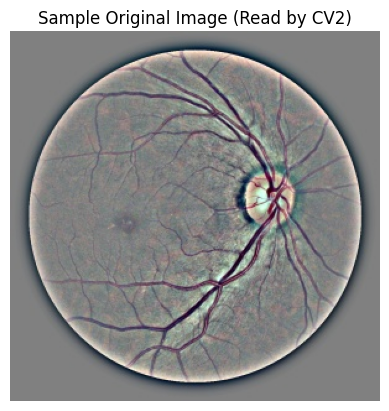

Sample image pixel range (min, max): 0 255
Sample image dtype: uint8


In [4]:
# CELL 4: Preprocessing Function (Simplified - Rely on Generator)

# We will rely on ImageDataGenerator for resizing and normalization during training.
# This function is mainly for visualizing or potentially for a standalone prediction pipeline.
def check_image_readable(image_path):
    """Checks if an image can be read by OpenCV."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image at {image_path}")
        return False
    return True

# Test reading a sample image
sample_path_to_check = df['image_path'].iloc[0]
if check_image_readable(sample_path_to_check):
    print(f"Successfully read sample image: {sample_path_to_check}")
    # Display original image (as read from disk)
    orig_img = cv2.cvtColor(cv2.imread(sample_path_to_check), cv2.COLOR_BGR2RGB)
    plt.imshow(orig_img)
    plt.title("Sample Original Image (Read by CV2)")
    plt.axis('off')
    plt.show()
else:
    print("Reading failed for the sample image.")

# IMPORTANT: Verification step (manual check recommended)
# Load one sample image and check its pixel value range *after* Ben Graham processing
sample_img_check = cv2.imread(df['image_path'].iloc[0])
print("Sample image pixel range (min, max):", np.min(sample_img_check), np.max(sample_img_check))
print("Sample image dtype:", sample_img_check.dtype)
# Based on the output (e.g., 0-255, uint8), confirm if rescale=1./255 in the generator is correct.
# Assuming it's 0-255 uint8, the rescale is needed.

In [ ]:
# CELL 5: MODIFIED (Data Generators - Use Oversampled Data, Refined Augmentation)

# NOTE: Assuming Ben Graham images are uint8 [0, 255]. If not, adjust rescale.
# Refined Augmentation: Removed vertical flip (less common for retina), adjusted ranges slightly.
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize to [0, 1] - CHECK if needed based on previous step!
    rotation_range=20, # Reduced range slightly
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15, # Consider [0.85, 1.15]
    horizontal_flip=True,
    # vertical_flip=False, # Typically not used for retinas
    brightness_range=[0.8, 1.2], # Keep brightness changes
    fill_mode='nearest', # How to fill newly created pixels
    validation_split=0.2 # Keep 20% of the (oversampled) train set for validation
)

# Validation/test generator - ONLY Rescaling (MUST match training rescale)
test_datagen = ImageDataGenerator(rescale=1./255) # CHECK if needed!

# Split the OVERSAMPLED data
train_df, test_df = train_test_split(
    df, # Use the balanced df
    test_size=0.2, # 20% for testing
    stratify=df['diagnosis_str'], # Stratify on the balanced data
    random_state=SEED
)

# Re-create validation split from the new train_df for the generator
# train_df itself is now used for BOTH training and validation subsets below

print(f"Train DF shape: {train_df.shape}")
print(f"Test DF shape: {test_df.shape}")


# Create generators using the GLOBAL batch size for multi-GPU
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='diagnosis_str',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=global_batch_size, # Use calculated global batch size
    class_mode='categorical',
    subset='training', # Specify training subset
    shuffle=True,
    seed=SEED
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df, # Use the same train_df
    x_col='image_path',
    y_col='diagnosis_str',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=global_batch_size, # Use calculated global batch size
    class_mode='categorical',
    subset='validation', # Specify validation subset
    shuffle=False, # No need to shuffle validation data
    seed=SEED
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='diagnosis_str',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=global_batch_size, # Use calculated global batch size
    class_mode='categorical',
    shuffle=False # DO NOT shuffle test data
)

# Class weights are LESS critical now due to oversampling, but can still help fine-tune.
# Calculate based on the OVERSAMPLED training set (before validation split)
classes_train = train_df['diagnosis'].values # Use the diagnosis column from the balanced training split
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes_train),
    y=classes_train
)
class_weights = {i: cw_val for i, cw_val in enumerate(cw)}
print("\nClass weights (calculated on oversampled training data):")
print(class_weights)

# --- Optional: Verify generator output ---
x_batch, y_batch = next(train_generator)
print("Batch shape:", x_batch.shape)
print("Batch pixel range (min, max):", np.min(x_batch), np.max(x_batch))
plt.imshow(x_batch[0])
plt.title(f"Class: {diagnosis_mapping[np.argmax(y_batch[0])]}")
plt.show()
# train_generator.reset() # Reset generator after peeking

In [ ]:
# CELL 6: MODIFIED (Model Building - Simpler Head)

def build_model(num_classes=N_CLASSES, img_size=IMG_SIZE, fine_tune=False, fine_tune_at_block=4):
    """
    Builds a ResNet50V2 model with a simpler classification head.

    Args:
        num_classes: Number of output classes.
        img_size: Input image size.
        fine_tune: Whether to unfreeze layers in the base model.
        fine_tune_at_block: Which ResNet block to start unfreezing (e.g., 4 or 5).
                           Lower number means unfreezing more layers. Block 5 starts around layer 155. Block 4 around 143.

    Returns:
        A TensorFlow Keras model.
    """
    input_shape = (img_size, img_size, 3)
    base_model = applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Determine the layer index to start fine-tuning from
    # Find indices for 'conv5_block1_out' or 'conv4_block1_out' etc.
    fine_tune_layer_name = f'conv{fine_tune_at_block}_block1_out' # Default to block 4
    try:
        fine_tune_at_index = [i for i, layer in enumerate(base_model.layers) if layer.name == fine_tune_layer_name][0]
        print(f"Fine-tuning from layer: {base_model.layers[fine_tune_at_index].name} (index {fine_tune_at_index})")
    except IndexError:
        print(f"Warning: Could not find layer name '{fine_tune_layer_name}'. Defaulting fine-tune index.")
        # A common index for starting fine-tuning deeper layers in ResNet50V2
        fine_tune_at_index = 143 # Approximate start of block 4

    if fine_tune:
        base_model.trainable = True
        # Freeze layers before the fine_tune_at_index
        for layer in base_model.layers[:fine_tune_at_index]:
            layer.trainable = False
        print(f"Fine-tuning enabled: {len(base_model.layers) - fine_tune_at_index} trainable layers in base model.")
    else:
        base_model.trainable = False
        print("Fine-tuning disabled: Base model frozen.")


    # Build the simplified head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(), # Add BN right after GAP
        layers.Dropout(0.4), # Moderate dropout
        layers.Dense(256, activation='relu'), # Smaller dense layer
        layers.BatchNormalization(),
        layers.Dropout(0.3), # Slightly less dropout
        layers.Dense(num_classes, activation='softmax') # Output layer
    ])
    return model

# --- Build and compile the model inside the strategy scope ---
if strategy: # If MirroredStrategy is active
    with strategy.scope():
        print("\nBuilding and compiling Phase 1 model within MirroredStrategy scope...")
        model = build_model(fine_tune=False)
        optimizer_ph1 = tf.keras.optimizers.Adam(learning_rate=LR_PHASE1)
        # OPTIONAL: Try Focal Loss here if imbalance is still extreme
        # loss_fn = tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0)
        loss_fn = 'categorical_crossentropy'
        model.compile(
            optimizer=optimizer_ph1,
            loss=loss_fn,
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] # Add AUC
        )
else: # Single GPU or CPU
     print("\nBuilding and compiling Phase 1 model for single device...")
     model = build_model(fine_tune=False)
     optimizer_ph1 = tf.keras.optimizers.Adam(learning_rate=LR_PHASE1)
     # loss_fn = tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0)
     loss_fn = 'categorical_crossentropy'
     model.compile(
         optimizer=optimizer_ph1,
         loss=loss_fn,
         metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] # Add AUC
     )

model.summary() # Display summary

In [ ]:
# CELL 7: MODIFIED (Phase 1 Training - Adjusted Callbacks/Epochs)

# Callbacks - Increased patience, monitor val_auc as well maybe?
# Monitoring val_loss is generally safer for EarlyStopping/ReduceLR
checkpoint_path_ph1 = 'model_phase1_best_oversampled.keras'
callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=PATIENCE_EARLY_STOPPING, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=PATIENCE_REDUCE_LR, min_lr=MIN_LR, verbose=1),
    ModelCheckpoint(checkpoint_path_ph1, monitor='val_loss', save_best_only=True, verbose=1)
    # Consider adding TensorBoard callback for more detailed logging
    # tf.keras.callbacks.TensorBoard(log_dir='./logs_phase1', histogram_freq=1)
]

print("\n--- Starting Phase 1 Training ---")
print(f"Epochs: {EPOCHS_PHASE1}, LR: {LR_PHASE1}, Batch Size (Global): {global_batch_size}")
print(f"Training samples: {train_generator.samples}, Validation samples: {validation_generator.samples}")

history_phase1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=validation_generator,
    callbacks=callbacks_phase1,
    class_weight=class_weights # Still use weights, they can help even with oversampling
    # steps_per_epoch=len(train_generator), # Usually inferred
    # validation_steps=len(validation_generator) # Usually inferred
)

# Plot training history (Phase 1)
print("\n--- Plotting Phase 1 History ---")
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history_phase1.history['loss'], label='Train Loss')
plt.plot(history_phase1.history['val_loss'], label='Val Loss')
plt.title("Phase 1 Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_phase1.history['accuracy'], label='Train Accuracy')
plt.plot(history_phase1.history['val_accuracy'], label='Val Accuracy')
plt.title("Phase 1 Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_phase1.history['auc'], label='Train AUC')
plt.plot(history_phase1.history['val_auc'], label='Val AUC')
plt.title("Phase 1 AUC")
plt.legend()

plt.tight_layout()
plt.show()

# --- Clean up memory ---
best_epoch_ph1 = np.argmin(history_phase1.history['val_loss']) + 1
print(f"Best Phase 1 epoch (based on val_loss): {best_epoch_ph1}")
# del model # Optionally delete model if building new one from scratch for phase 2
# gc.collect() # Force garbage collection
# tf.keras.backend.clear_session() # Be careful with this in notebooks

In [ ]:
# CELL 8: MODIFIED (Phase 2 Fine-Tuning - Adjusted Callbacks/Epochs/LR, Correct Weight Loading)

print(f"\n--- Preparing for Phase 2 Fine-Tuning ---")
# It's generally safer to load the best weights into the *same* model instance
# and then make layers trainable, rather than building a new model and transferring weights,
# especially with distributed strategies. However, your previous method also works.
# Let's stick to modifying the existing model instance after loading best weights.

print(f"Loading best weights from Phase 1: {checkpoint_path_ph1}")
# Ensure model is loaded within strategy scope if needed, but load_weights usually works outside too
model.load_weights(checkpoint_path_ph1)

# --- Modify the loaded model for fine-tuning ---
if strategy:
    with strategy.scope():
        print("Setting layers trainable and recompiling within strategy scope...")
        # Make base model layers trainable (according to fine_tune_at_block logic in build_model)
        base_model = model.layers[0] # Get the base model
        base_model.trainable = True
        fine_tune_at_block = 4 # Match the setting used in build_model definition (or adjust)
        fine_tune_layer_name = f'conv{fine_tune_at_block}_block1_out'
        try:
            fine_tune_at_index = [i for i, layer in enumerate(base_model.layers) if layer.name == fine_tune_layer_name][0]
        except IndexError:
            fine_tune_at_index = 143 # Fallback index

        for layer in base_model.layers[:fine_tune_at_index]:
            layer.trainable = False
        print(f"Fine-tuning enabled: {len(base_model.layers) - fine_tune_at_index} trainable layers in base model.")

        # Re-compile the *existing* model with a lower learning rate
        optimizer_ph2 = tf.keras.optimizers.Adam(learning_rate=LR_PHASE2) # Use lower LR
        # loss_fn = tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0) # Optional focal loss
        loss_fn = 'categorical_crossentropy'
        model.compile(
            optimizer=optimizer_ph2,
            loss=loss_fn,
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] # Keep same metrics
        )
else:
    print("Setting layers trainable and recompiling for single device...")
    base_model = model.layers[0]
    base_model.trainable = True
    fine_tune_at_block = 4
    fine_tune_layer_name = f'conv{fine_tune_at_block}_block1_out'
    try:
        fine_tune_at_index = [i for i, layer in enumerate(base_model.layers) if layer.name == fine_tune_layer_name][0]
    except IndexError:
        fine_tune_at_index = 143
    for layer in base_model.layers[:fine_tune_at_index]:
            layer.trainable = False
    print(f"Fine-tuning enabled: {len(base_model.layers) - fine_tune_at_index} trainable layers in base model.")

    optimizer_ph2 = tf.keras.optimizers.Adam(learning_rate=LR_PHASE2)
    # loss_fn = tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0)
    loss_fn = 'categorical_crossentropy'
    model.compile(
        optimizer=optimizer_ph2,
        loss=loss_fn,
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

model.summary() # Summary now shows trainable base layers

# Callbacks for Phase 2
checkpoint_path_ph2 = 'model_phase2_best_oversampled_finetuned.keras'
callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=PATIENCE_EARLY_STOPPING, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=PATIENCE_REDUCE_LR, min_lr=MIN_LR, verbose=1),
    ModelCheckpoint(checkpoint_path_ph2, monitor='val_loss', save_best_only=True, verbose=1)
    # tf.keras.callbacks.TensorBoard(log_dir='./logs_phase2', histogram_freq=1)
]

print("\n--- Starting Phase 2 Fine-Tuning ---")
print(f"Epochs: {EPOCHS_PHASE2}, LR: {LR_PHASE2}, Batch Size (Global): {global_batch_size}")
print(f"Training samples: {train_generator.samples}, Validation samples: {validation_generator.samples}")


history_phase2 = model.fit( # Use the same 'model' instance
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=validation_generator,
    callbacks=callbacks_phase2,
    class_weight=class_weights, # Continue using class weights
    initial_epoch=0 # Start fine-tuning epochs from 0
    # If you want to continue epoch numbers: initial_epoch=history_phase1.epoch[-1] + 1
)


# Plot training history (Phase 2)
print("\n--- Plotting Phase 2 History ---")
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history_phase2.history['loss'], label='Train Loss')
plt.plot(history_phase2.history['val_loss'], label='Val Loss')
plt.title("Phase 2 Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_phase2.history['accuracy'], label='Train Accuracy')
plt.plot(history_phase2.history['val_accuracy'], label='Val Accuracy')
plt.title("Phase 2 Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_phase2.history['auc'], label='Train AUC')
plt.plot(history_phase2.history['val_auc'], label='Val AUC')
plt.title("Phase 2 AUC")
plt.legend()

plt.tight_layout()
plt.show()

# --- Clean up ---
best_epoch_ph2 = np.argmin(history_phase2.history['val_loss']) + 1 # Adjust if using initial_epoch
print(f"Best Phase 2 epoch (based on val_loss): {best_epoch_ph2}")
# Optional cleanup
# del model # We need the final model for evaluation
# gc.collect()
# tf.keras.backend.clear_session()

In [ ]:
# CELL 9: MODIFIED (Evaluation - Use Balanced Accuracy)

# Load the best model saved during fine-tuning
print(f"\n--- Evaluating Best Fine-Tuned Model ---")
print(f"Loading model from: {checkpoint_path_ph2}")

# Load the best performing model from phase 2 fine-tuning
if strategy:
    with strategy.scope():
        # It's often recommended to load within the scope, although sometimes works outside
        model_final = tf.keras.models.load_model(checkpoint_path_ph2)
else:
    model_final = tf.keras.models.load_model(checkpoint_path_ph2)


print("\nEvaluating on Test Set...")
# Ensure test generator is reset (though shuffle=False should make it deterministic)
test_generator.reset()
results = model_final.evaluate(test_generator, verbose=1)

# Print metrics from evaluate()
print("\nTest Loss, Test Accuracy, Test AUC:")
print(results)

print("\nGenerating Predictions on Test Set...")
test_generator.reset() # Reset again just to be sure
y_pred_probs = model_final.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) # Get class names mapping
class_names = [diagnosis_mapping[int(cls_idx_str)] for cls_idx_str in class_labels] # Map string indices '0','1'.. to names

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=3))

# --- NEW: Calculate Balanced Accuracy ---
bal_acc = balanced_accuracy_score(y_true, y_pred_classes)
print(f"\nBalanced Test Accuracy: {bal_acc:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# CELL 10: MODIFIED (Single Image Prediction - Align Preprocessing)

# We don't need the separate preprocess_image function if we align with the generator
# The generator applies rescale=1./255. Prediction should do the same.

# Load the final best model again (or use model_final if still in memory)
# model_to_predict = tf.keras.models.load_model(checkpoint_path_ph2)
model_to_predict = model_final # Use the already loaded final model

def predict_single_image(image_path, model, img_size=IMG_SIZE):
    """
    Loads, preprocesses (matching generator), and predicts a single image.
    """
    try:
        img = tf.keras.preprocessing.image.load_img(
            image_path, target_size=(img_size, img_size)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        # --- IMPORTANT: Apply the SAME preprocessing as the generator ---
        # Assuming rescale=1./255 was used:
        img_array = img_array / 255.0
        # If no rescale was used, comment the line above.
        # If other preprocessing like tf.keras.applications.resnet_v2.preprocess_input was used, apply that here.

        img_batch = np.expand_dims(img_array, axis=0) # Create batch dim

        predictions = model.predict(img_batch)
        predicted_class_index = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_index]

        # Get class names directly from the mapping based on index
        predicted_class_name = diagnosis_mapping[predicted_class_index]
        probabilities = {diagnosis_mapping[i]: prob for i, prob in enumerate(predictions[0])}

        return {
            'predicted_class': predicted_class_name,
            'confidence': confidence,
            'probabilities': probabilities,
            'processed_image_array': img_array # Return the processed array used for prediction
        }
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Test prediction on a sample test image
# sample_image_path = test_df['image_path'].iloc[0] # Use an image from the test set
sample_image_path ='/kaggle/input/diabetic-retinopathy-dataset-ben-graham-applied/DIABETIC_RETINOPATHY_DATASET_BELL_GRAHAM_PROCESSED/BELL_GRAHAM_SEGREGATED/Severe/1008_left.jpeg' # Or keep your specific example

print(f"\n--- Predicting single image: {sample_image_path} ---")
result = predict_single_image(sample_image_path, model_to_predict)

if result:
    print(f"Predicted Class: {result['predicted_class']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("Class Probabilities:", result['probabilities'])

    # Display original and the array that went into the model
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    orig_img = cv2.cvtColor(cv2.imread(sample_image_path), cv2.COLOR_BGR2RGB)
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    # Display the processed array (should be normalized [0,1])
    plt.imshow(result['processed_image_array'])
    plt.title("Processed Image (as fed to model)")
    plt.axis('off')
    plt.show()
else:
    print("Prediction failed.")

In [ ]:
# CELL 11: MODIFIED (Save Final Model)

# Save the final model (best one from phase 2)
final_model_save_path = '/kaggle/working/diabetic_retinopathy_resnet50v2_oversampled_final.keras'
print(f"\n--- Saving final model to {final_model_save_path} ---")
model_final.save(final_model_save_path)
print("Model saved successfully.")

# Optional: Test loading the final saved model
# print("\nTesting loading the saved final model...")
# loaded_final_model = tf.keras.models.load_model(final_model_save_path)
# print("Model loaded successfully.")
# loaded_result = predict_single_image(sample_image_path, loaded_final_model)
# if loaded_result:
#     print("Loaded Model Prediction:", loaded_result['predicted_class'])
# else:
#     print("Prediction failed with loaded model.")

print("\n--- Notebook execution finished ---")